# Simulating a Multi-Session Observation of the Sky with the Green Bank Telescope

This notebook models sky scans performed over multiple nights using the Green Bank Telescope (GBT).  
It simulates sky coverage with the goal of visualizing and analyzing the total observational footprint.

---

## Imports and Constants


In [1]:
import os
import requests

import healpy as hp

from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

from datetime import datetime
from zoneinfo import ZoneInfo

from AltAzSim import Telescope, ScanSession, ScanProject
from AltAzSim.scantypes import BackAndForthScan
from AltAzSim.coveragemap import CoverageMap, Overlay, uncover_maps, convert_nside


# The GBT is located in the Eastern Time Zone
EST_TZ = ZoneInfo("America/New_York")

# We are using the Green Bank Telescope for all of our observations
GBT = Telescope(
    location= EarthLocation.of_site('Green Bank Telescope'),
    az_slew= 17.6 * (u.deg/u.min),
    tip_slew= 17.6 * (u.deg/u.min),
    az_accel= .2 * (u.deg/u.s**2),
    tip_accel= .2 * (u.deg/u.s**2),
    max_alt= 90 * u.deg,
    min_alt= 5 * u.deg,
    max_az= 365 * u.deg,
    min_az= -5 * u.deg,
    angular_res= 1 * (u.deg**2)
)

# cap the number of scans displayed at 10, otherwise points like the ncp will dominate, as we scan over it many times
THRESHOLD = 10

### Coldest Patch

An important region of the sky for this project is known as the **"coldest patch"**, which—just as the name suggests—is the area with the lowest radio emission. Here we are gatthering all pixels within a radius of 2 degrees to display on our maps

#### `Overlay`

Used to overlay points on coverage maps. These do not alter the underlying "pass" values of the map.

**Attributes**:
- `coord` (*SkyCoord*): The coordinate of the point to be overlayed
- `color` (*str*): The color of the overlay point. Can provide hex values
- `radius` (*Quantity*): The radius of the overlay point

In [2]:
# The galactic and Ra and Dec coords of the "Coldest Patch"
CP_GALACTIC = SkyCoord(l=196.0 * u.deg, b=48.0 * u.deg, frame='galactic')
CP_RA_DEC = SkyCoord(ra="09h38m41s", dec="+30d49m12s", frame='icrs')

cp_radec_overlay = Overlay(CP_RA_DEC, "red", 2 * u.deg)
cp_gal_overlay = Overlay(CP_GALACTIC, "red", 2 * u.deg)

## Setting Up the Types of Scans

### `BackAndForthScan`


A simple scan pattern that fixes one axis and slews back and forth between two extremes on the other axis.

Use `BackAndForthScan.from_duration(...)` if you want to specify how long the scan should last,  
or `BackAndForthScan.from_count(...)` if you want to specify how many back-and-forth sweeps to do.  

**Attributes:**
- `scan_mode` (*str*): `"az"` for azimuth scans, or `"tip"` for tip (elevation) scans.
- `min_angle`, `max_angle` (*Quantity*): Limits of the scanning axis.
- `fixed_deg` (*Quantity*): The angle to hold fixed during the scan.
- `slew` (*Quantity*): Slew speed of the active axis.
- `duration` (*Quantity*): Total scan time (used if created via `.from_duration`).
- `count` (*int*): Number of full sweeps (used if created via `.from_count`).
- `config` (*dict*, optional): Used to configure how the scan works. Use `.get_default_config()` to see options.

> A sweep here means one pass from `min_angle` to `max_angle` or vice versa.


#### Mechanics of BackAndForthScan

- **Starting outside the scan range**  
  The first sweep is counted when the telescope reaches the *opposite extreme* of the scan range.  
  **Example**: Starting at 88° altitude with a scan range of 37° to 5°, the first sweep is counted when 5° is reached.

- **Starting on a scan limit**  
  Same behavior as above. The first sweep is counted when the opposite limit is reached.  
  **Example**: Starting at 37° with a range of 37° to 5°, the first sweep is counted when 5° is reached.

- **Starting within the scan range**  
  The first sweep is counted **after reaching one limit and then returning to the other**.  
  **Example**: Starting at 27° with a range of 37° to 5°, the first sweep is counted after first going to 5° and then 37°.

In [3]:
half_az_2hr = BackAndForthScan.from_duration(
    scan_mode= "az",
    max_angle= 180 * u.deg,
    min_angle= GBT.min_az,
    slew= GBT.az_slew,
    fixed_deg= 38 * u.deg,
    duration= 2 * u.hr
)

tip_scan_1x = BackAndForthScan.from_count(
    "tip",
    38 * u.deg,
    5 * u.deg,
    GBT.tip_slew,
    180 * u.deg,
    count= 1
)

tip_south_10hr = BackAndForthScan.from_duration(
    "tip",
    90 * u.deg,
    GBT.min_alt,
    GBT.tip_slew,
    180 * u.deg,
    10 * u.hr
)

## Setting Up Scanning Sessions

#### `ScanSession`


**Attributes:**
- `telescope` (*Telescope*): The telescope instance used for this session.
- `start_time` (*datetime*): When the session begins.
- `scans` (*ScanProfile* or *list of ScanProfile*): A single scan or a list of scans to execute.
- `init_el` (*Quantity*, optional): Initial altitude of the telescope at the start of the session. Default is None; if None, defaults to telescope.min_alt.
- `init_az` (*Quantity*, optional): Initial azimuth of the telescope at the start of the session. Default is None; if None, defaults to telescope.min_az.

**Methods:**
- `run_scans(frame)`: Simulates all scans in the session and populates a sky map. Expect several seconds to minutes to complete.
- `display_maps(threshold, overlays, show_titles, show_unit_bars)`: Displays the total coverage map for the ession and each individual map.
- `save_session_pdf(save_loc, threshold, overlays, show_titles, show_unit_bars)`: Saves the coverage maps and metadata for the session as a pdf.

In [4]:
regular_scans = [half_az_2hr, tip_scan_1x, half_az_2hr, tip_scan_1x, half_az_2hr, tip_scan_1x, half_az_2hr, tip_scan_1x]

feb_26 = datetime(2026, 2, 1, 20, 0, 0, tzinfo=EST_TZ)
session_1 = ScanSession(
    GBT,
    feb_26,
    regular_scans
)

may_26 = datetime(2026, 5, 1, 20, 0, 0, tzinfo=EST_TZ)
session_2 = ScanSession(
    GBT,
    may_26,
    regular_scans
)

oct_26 = datetime(2026, 10, 1, 20, 0, 0, tzinfo=EST_TZ)
session_3 = ScanSession(
    GBT,
    oct_26,
    regular_scans
)

feb_27 = datetime(2027, 2, 1, 20, 0, 0, tzinfo=EST_TZ)
session_4 = ScanSession(
    GBT,
    feb_27,
    tip_south_10hr
)

may_27 = datetime(2027, 5, 1, 20, 0, 0, tzinfo=EST_TZ)
session_5 = ScanSession(
    GBT,
    may_27,
    tip_south_10hr
)

oct_27 = datetime(2027, 10, 1, 20, 0, 0, tzinfo=EST_TZ)
session_6 = ScanSession(
    GBT,
    oct_27,
    tip_south_10hr
)

## Run the Scans and Display the Maps

### A Single Session

#### `ScanSession.run_scan(frame)`


Runs a simulation for the scan types defined in the `ScanSession` instance and populates a map for visualization. \
Expect several seconds to complete.

**Parameters:**
- `frame` (*str*): The coordinate frame you want your scan to be displayed in. \
  Options: `"galactic"`, `"ra_dec"` (equivalent to `"icrs"`) \
  Default: `"ra_dec"` 

**Returns:**
- `None`

In [5]:
session_3.run_scans()

#### `ScanSession.display_maps(threshold, overlays, show_titles, show_unit_bars)`


Displays a visualized map of the complete scan, with optional overlays and thresholding.

If using a notebook, will display inline, otherwise, a pop-up window will open.

**Parameters:**
- `threshold` (*int*, optional): Maximum number of passes to display. All pixels with values greater than or equal to `threshold` will be capped.  

- `overlays` (*Overlay*, *list of Overlay*, optional): Points to be overlayed on the coverage map

- `show_titles` (*bool*): If True, titles are displayed for each coverage map. If False, no title is displayed for every map. Default is True

- `show_unit_bars` (*bool*): If True, unit bars are displayed for each coverage map. If False, no unit bar is displayed for every map. Default is True


**Returns:**
- `None` — displays the scan as a rendered image.



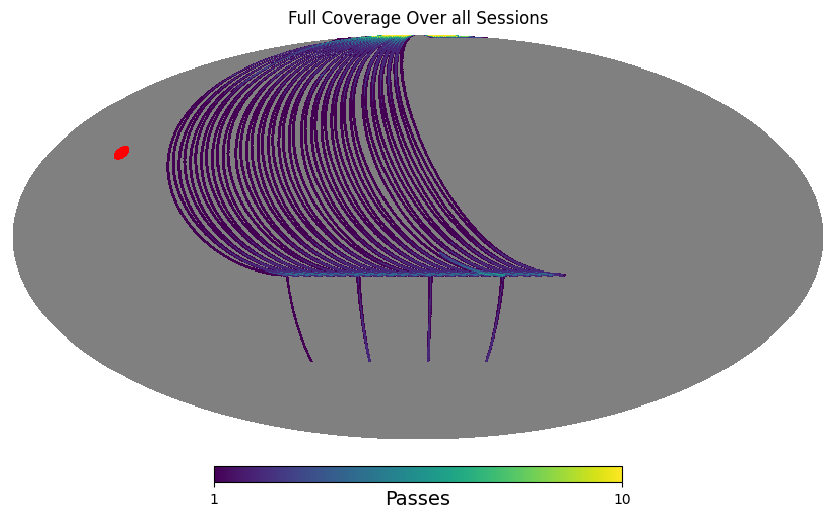

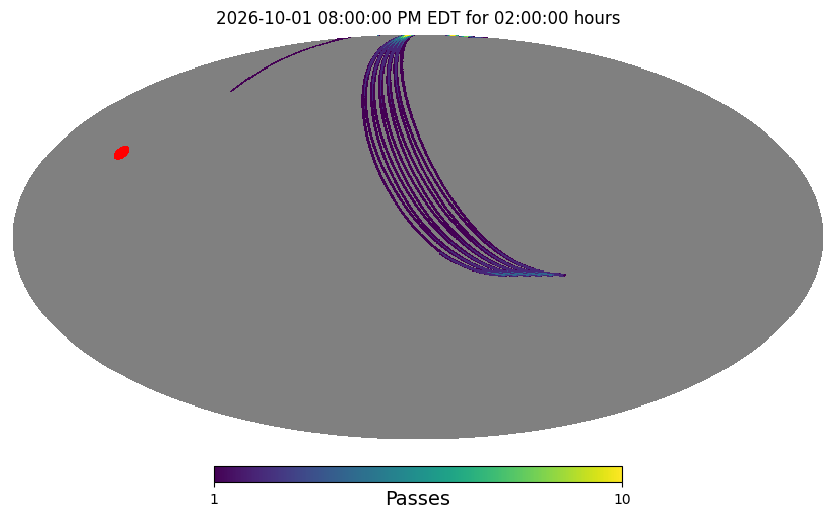

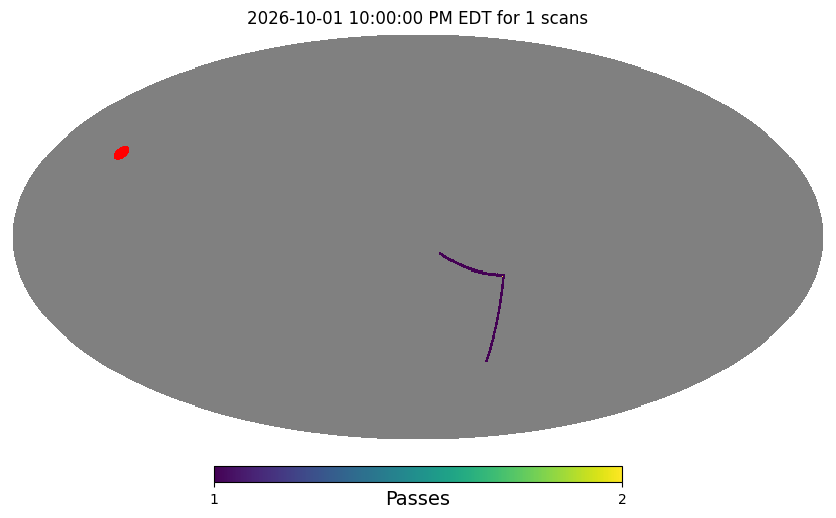

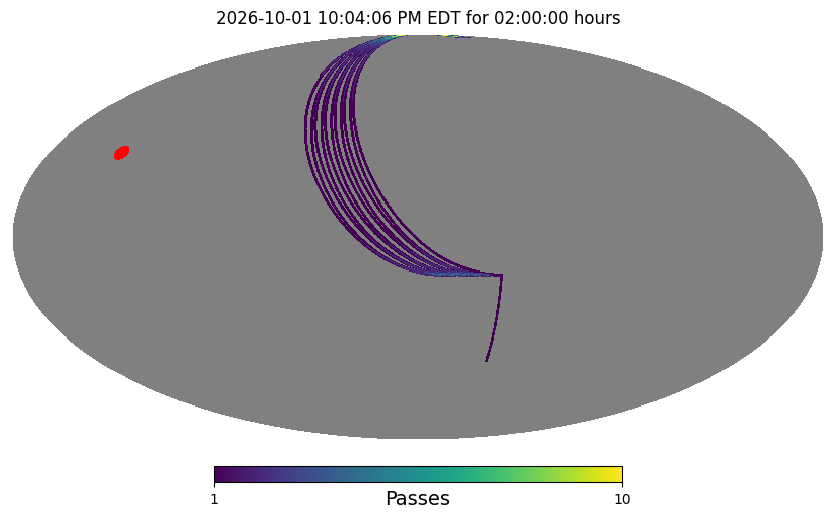

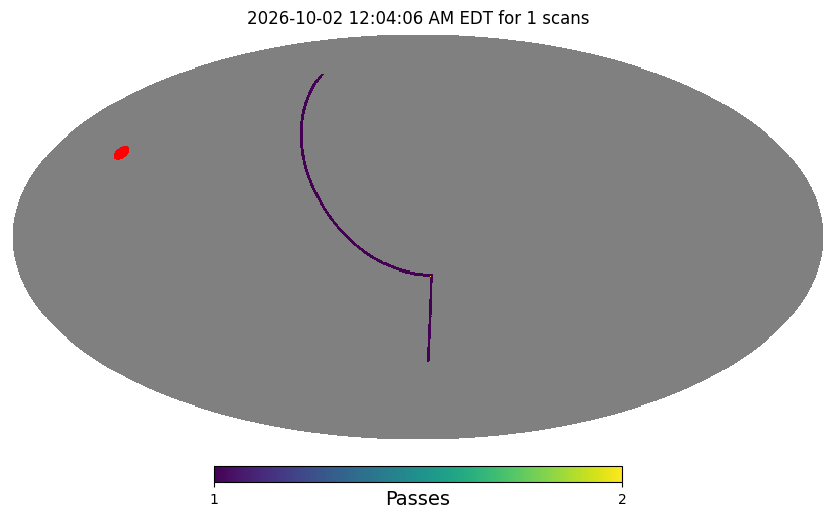

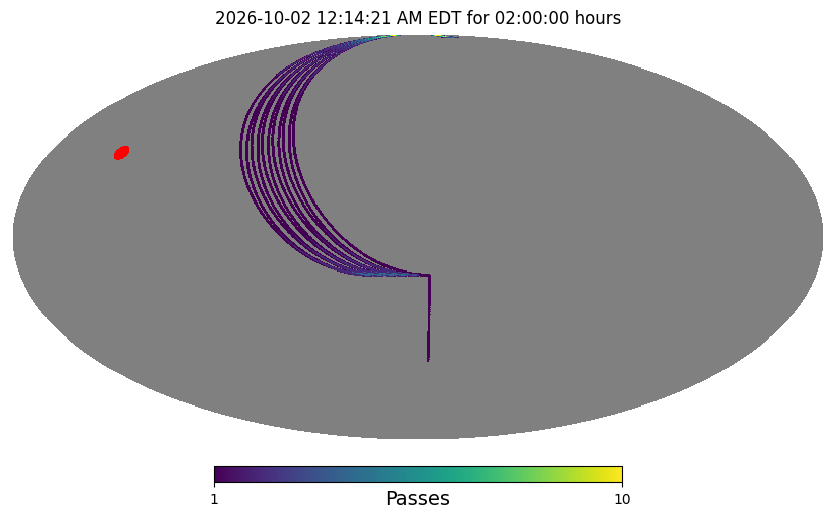

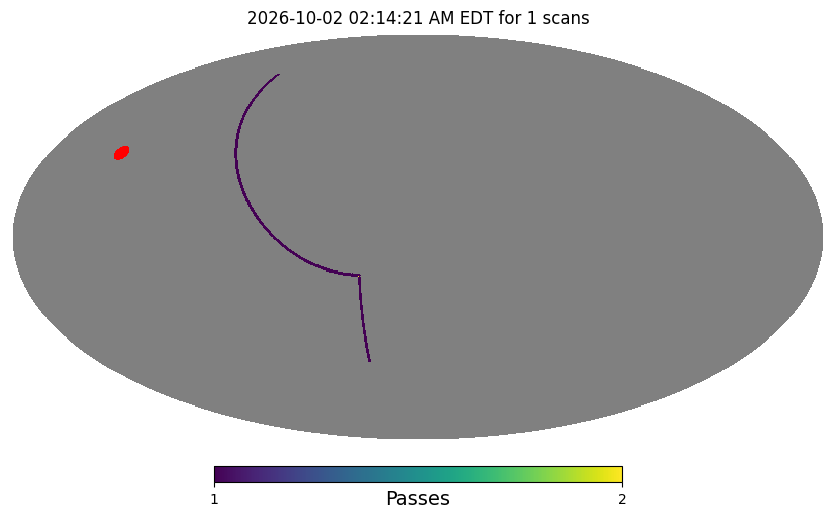

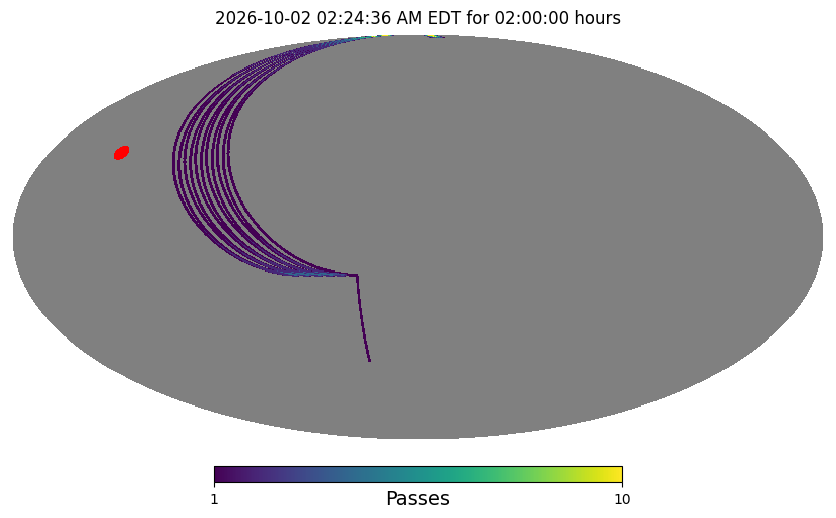

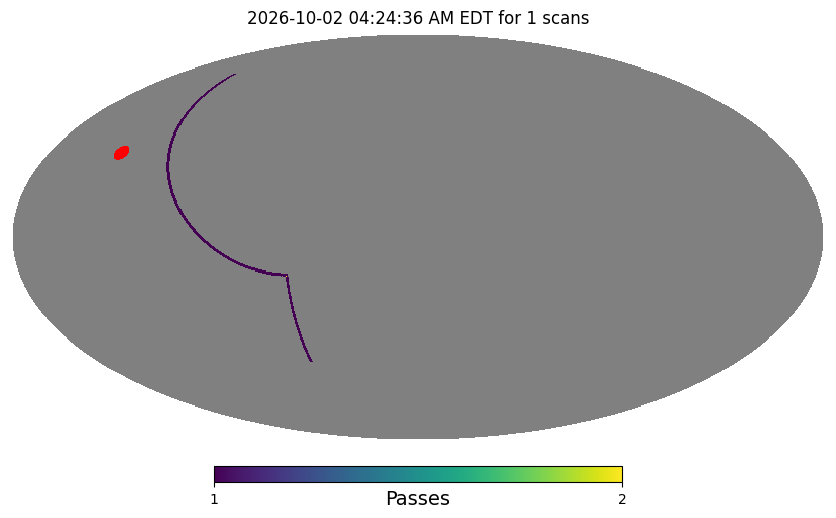

In [6]:
THRESHOLD = 10
session_3.display_maps(threshold=THRESHOLD, overlays=cp_radec_overlay)

### Multiple Sessions at Once

#### `ScanProject`

Used to bundle multiple ScanSession instances together. Functions very similarly to ScanSessions

**Attributes**
- `sessions` (*list of ScanSession*): The scan sessions used to make up the project
- `project_name` (*str*): Name of your project. Default is "Project"

**Methods**
- `run_scans(frame)`: Simulates all scans in each session and populates a sky map. Expect several seconds to minutes to complete.
- `display_maps(threshold, overlays, show_titles, show_unit_bars)`: Displays the total coverage map for the project and each session map (indivdual maps from sessions are not displayed).
- `save_session_pdf(save_loc, threshold, overlays, show_titles, show_unit_bars)`: Saves the project and session maps and metadata for the project as a pdf.

In [7]:
project_observations = [session_1, session_2, session_3, session_4, session_5, session_6]

GBT_project = ScanProject(project_observations, "GBT 310 Project")
GBT_project.run_scans("galactic") #expect ~40 seconds to run

#### `CoverageMap.set_display_pref(show_title, show_unit_bar, threshold)`

Sets the display preferences for the map when using `CoverageMap.display()`

**Parameters**:
- `show_title` (*bool*): If True, title is displayed. If False, no title is displayed. Default is True

- `show_unit_bar` (*bool*): If True, unit bar is displayed. If False, no unit bar is displayed. Default is True.

- `threshold` (*int*, optional): Maximum number of passes to display. All pixels with values greater than or equal to `threshold` will be capped.

- `norm` (*str*): Controls how values in your map are normalized (i.e use "log" for log based normalization) 

**Returns**:
- `None`

In [8]:
GBT_project.coverage_map.set_display_pref(threshold=THRESHOLD)

#### `CoverageMap.display(overlays)`

Displays the coverage map. If using a notebook, will display inline, otherwise, a pop-up window will open.

**Parameters**
- `overlays` (*Overlay*, *list of Overlay*, optional): Points to be overlayed on the coverage map

**Returns:**
- `None` - displays the coverage map

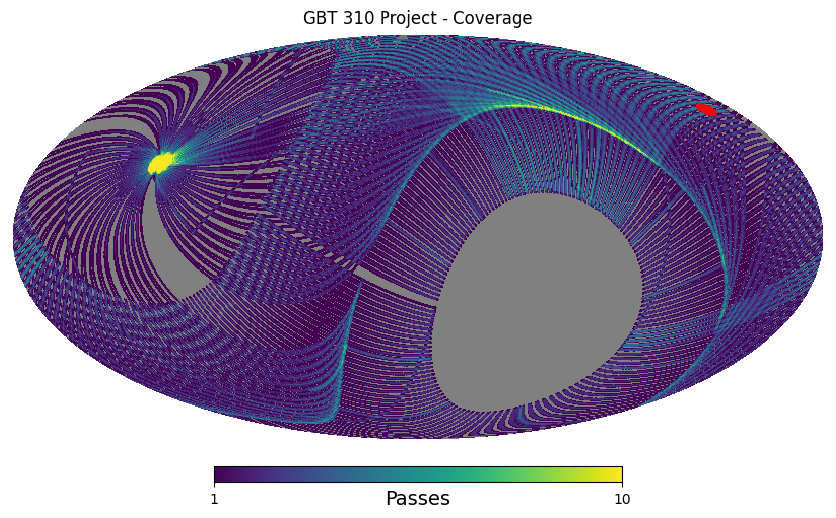

In [9]:
GBT_project.coverage_map.display(cp_gal_overlay)

## Working with Pre-Existing Maps

### Pulling the Haslam map from Nasa's website

In [10]:
haslam_url = "https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_dsds_Remazeilles2014.fits"
haslam_file = "haslam408_dsds_Remazeilles2014.fits"

if not os.path.exists(haslam_file):
    with requests.get(haslam_url, stream=True) as r:
        r.raise_for_status()
        with open(haslam_file, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

### `convert_nside(maps, new_nside)`


Healpy is used under the hood to create the maps. nside corresponds to the resolution of the map. The default is 2^10, or 1,024. This can be changes by importing config.

Converts a coverage map to a new nside. Here we are working with the nside=512 Haslam map, but our coverage map is nside=1024, so we'll convert ours to nside=512

**Parameters:**
- `maps` (*CoverageMap*, *list of CoverageMap*): The coverage maps to be converted.
- `new_nside` (*int*): The nside to be converted to.

**Returns:**
- `CoverageMap` or *list of* `CoverageMap` - Copies of the coverage maps in maps

In [11]:
project_coverage_map = convert_nside(GBT_project.coverage_map, 512)

### Preparing Haslam map

In [12]:
haslam = hp.read_map(haslam_file)

haslam = CoverageMap.from_map(haslam, "Haslam 408MHz")
haslam.unit = "K (log scale)"

### Uncovering Haslam with our project coverage map

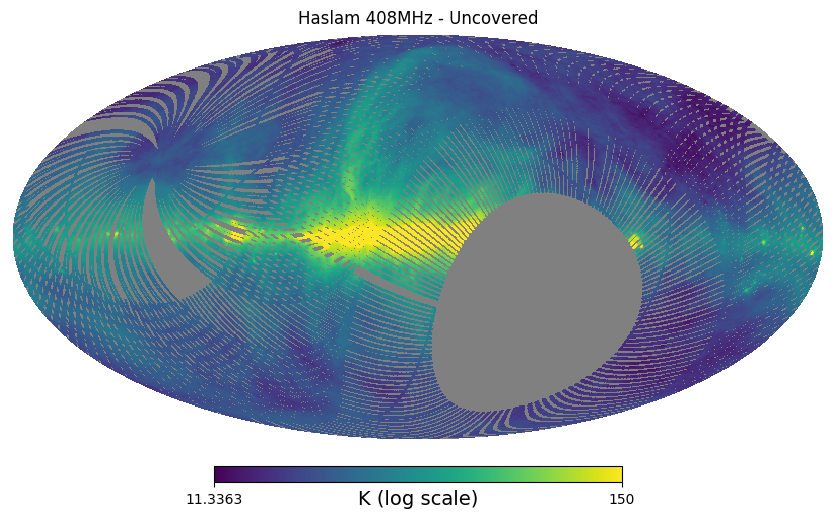

In [13]:
uncovered_haslam = uncover_maps(project_coverage_map, haslam)
uncovered_haslam.set_display_pref(norm="log", threshold=150)
uncovered_haslam.display()

## Saving as A PDF

### `ScanProject.save_project_pdf(save_loc, threshold, overlays, show_titles, show_unit_bars)`

Saves the total coverage map from all sessions, and the maps from each session, but not individual scans within each session. 

Gives start and end times, session durations, session sky coverage and total sky coverage.

**Parameters**
- `save_loc` (*str*): The location where the pdf should be saved

- `threshold` (*int*, optional): The maximum number of passes to be displayed. All passes greater than this will be set to threshold. Deafult is None

- `overlays` (*Overlay*, *list of OverLay*, optional): Points to be overlayed on maps. Default is None

- `show_titles` (*bool*): If True, title is displayed. If False, no title is displayed. Default is True

- `show_unit_bars` (*bool*): If True, unit bar is displayed. If False, no unit bar is displayed. Default is True

**Returns**
- `None`

In [14]:
GBT_project.save_project_pdf("GBT_project.pdf", threshold=THRESHOLD, show_unit_bars=False, overlays=cp_gal_overlay)

### `ScanSession.save_session_pdf(save_loc, threshold, overlays, show_titles, show_unit_bars)`

See the [ScanProject](#scanprojectsave_project_pdfsave_loc-threshold-overlays-show_titles-show_unit_bars) version. Functionality is the same, execpt that it saves the session scans and each individual scan and metadata is more detailed

In [15]:
session_3.save_session_pdf("october_26_session.pdf", threshold=THRESHOLD)

## Retrieving Scan Data from ScanSession

If you try to acces data directly from `session_1`, you'll get an error, becuase this scan wasn't individually run (it was ran through a `ScanProject` instance).

Accessing `session_3` directly doesnt raise and error because it was run individually.

This is also the case for accessing `ScanProfile` information from `ScanSession`

In [16]:
try:
    session_1.coverage_map.display()
except AttributeError as e:
    print("Can't access session_1 because it was not run individually")

session_1 = GBT_project.sessions[0]
print(f"Percent of sky covered from session 1: {session_1.sky_coverage * 100:.2f}%")

Can't access session_1 because it was not run individually
Percent of sky covered from session 1: 14.52%
